# Analysis of monkey experiments
**Copyright 2023 (c) Naomi Chaix-Echel & Nicolas P Rougier**  
Released under a BSD 2-clauses license

Implementation of the method introduced in [Estimating Prospect Theory Parameters with Maximum Likelihood in R](https://www.thegreatstatsby.com/posts/2021-03-08-ml-prospect/) in order to estimate loss aversion and diminishing marginal utility. 


## Common packages / functions

In [3]:
%run "00-common.ipynb"

## Load data

In [4]:
data = pd.read_csv("./data/data-processed.csv", parse_dates=["date"])
subject_ids = data['subject_id'].unique()
valid_ids, reject_ids = filter_subjects(data)
task_ids = list(range(1,8))

## Subjective utility

Subjective utility $u(x)$ is defined as: 

$
\begin{align}
u(x) = \left\{
    \begin{array}{ll}
        x^\rho & x \gt 0 \\
        -\lambda \cdot (-x)^{\rho} & x \le 0
    \end{array}
\right.
\end{align}
$

This function includes two parameters that correspond to the variables of interest:
* **loss aversion** (denoted by the Greek symbol lambda, λ)
* **diminishing marginal utility** (denoted by the Greek symbol rho, ρ)

In [5]:
def subjective_utility(X, p):
    """ Subjective utility of X """

    return np.where(X > 0, np.power(np.abs( X), p["rho"]),
                           -p["lambda"] * np.power(np.abs(X), p["rho"]))

## Subjective probability

Subjective probability $w(x)$ is defined as: 

$
\begin{align}
w(x) = e^{-(-log(x))^\alpha}
\end{align}
$


In [6]:
def subjective_probability(X, p):
    "Subjective probability of X"

    return np.exp(- np.power((-np.log(X)), p["alpha"]))

## Accept probability


$
\begin{align}
p(x) = \frac{1}{1-e^{-\mu(x-x_0)}}
\end{align}
$

In [7]:
def accept(X, bias, p=None):
    """
    Probability of accepting a gamble, given a difference X
    
    Individual biases are needed when X derives from the conversion
    of left/right to risky/safe. In other case, it can be a scalar.
    
    """
    
    if p is None:
        p = bias
        bias = p["bias"]
        
    P = 1/(1.0 + np.exp(-p["mu"]*(X - p["x0"] + bias)))
    # P = 1/(1.0 + np.exp(-p["mu"]*(X - p["x0"])))
    epsilon = 1e-10
    return np.maximum(np.minimum(P, 1-epsilon), epsilon)

## Log likelihood

$
\begin{align}
LL = - \sum_{i=0}^{i=n} y_i \cdot \log(p(accept_i)) + (1-y_i)\cdot \log(1-p(accept_i))
\end{align}
$

In [8]:
def log_likelihood(Y, P_risky, V_risky, P_safe, V_safe, bias, p):
    """ Compute the log likelihood  """
    
    R = subjective_probability(P_risky, p) * subjective_utility(V_risky, p)
    S = subjective_probability(P_safe, p) * subjective_utility(V_safe, p)
    P = accept(R - S, bias, p)
    log_likelihood = Y*np.log(P) + (1-Y)*(np.log(1-P))
    return -log_likelihood.sum()


## Fit evaluation (post optimization)

In [9]:
def evaluate(trials, p):
    """ Compate actual choices with their estimation """

    Y = trials["response"]
    P_risky, V_risky = trials["P_risky"], trials["V_risky"]
    P_safe, V_safe = trials["P_safe"], trials["V_safe"]
    bias = trials["bias"]
    
    R = subjective_probability(P_risky, p) * subjective_utility(V_risky, p)
    S = subjective_probability(P_safe, p) * subjective_utility(V_safe, p)
    P = accept(R - S, bias, p) > 0.5

    return Y.sum(), P.sum()

## Fit prospect theory parameters

### Parameters for the fit

In [10]:
# Number of trials to skip at the start (because monkeys are still learning the task)
# 200 is an abitrary number. It could certainly be found automatically based on response time.
skipped_trials = 200

# Initial guess for parameters
X0 = np.array([0,   # x0
               1,   # mu
               1.5, # alpha
               1,   # lambda
               1])  # rho

# Parameter bounds
bounds = np.array([(-5, 5),     # x0
                   (0.01, 3),   # mu
                   (0.01, 2),   # alpha
                   (0.01, 3),   # lambda
                   (0.01, 3)])  # rho

fits = {}

### Actual fit procedure

<div class="alert alert-block alert-warning">
<b>Warning:</b> This takes a few seconds</div>


In [11]:
def objective(X, Y, P_risky, V_risky, P_safe, V_safe, bias):
    params = {"x0" : X[0], "mu" : X[1], "alpha" : X[2], "lambda" : X[3], "rho" : X[4]}
    return log_likelihood(Y, P_risky, V_risky, P_safe, V_safe, bias, params)

with tqdm(total=len(valid_ids)) as progress:
    for subject_id in valid_ids:

        trials = select_trials(convert_trials(data, subject_id, [6,7])).copy()
        trials.sort_values(by='date', inplace = True)
        trials = trials[skipped_trials:]    
    
        # Do we normalize values for keping things between -1, +1 ?
        Y = trials["response"]
        P_risky, V_risky = trials["P_risky"], trials["V_risky"]
        P_safe, V_safe = trials["P_safe"], trials["V_safe"]
        bias = trials["bias"]
    
        # X0 = np.random.uniform(low=bounds[:,0], high=bounds[:,1])
        # X0 = X0 + .75*np.random.uniform(-1,1,X0.shape)
   
        res = minimize(objective, x0=X0, bounds=bounds,
                                  method="L-BFGS-B", tol=1e-10,
                                  options={"maxiter": 1000, "disp" : False },
                                  args = (Y, P_risky, V_risky, P_safe, V_safe, bias))

        X = res.x
        params = { "x0" : X[0], "mu" : X[1], "alpha" :  X[2], "lambda" : X[3], "rho" : X[4]}    
        fits[subject_id] = params
        progress.update()


  0%|          | 0/14 [00:00<?, ?it/s]

### Evaluate fit by comparing actual gambles with model gambles

The closer the ratio to 1.0, the better


In [12]:
mean_perf = 0

for subject_id in valid_ids:
    
    params = fits[subject_id]
    
    trials = convert_trials(select_trials(data, subject_id, [6])).copy()
    trials.sort_values(by='date', inplace = True)
    trials = trials[skipped_trials//2:]    
    truth, model = evaluate(trials, params) 
    print("%s: Gain (n=%5d): %.2f (%d / %d)" % (subject_id, len(trials), truth/max(model,1), truth, model))
    mean_perf += .5*abs(1-truth/max(model,1))
    
    trials = convert_trials(select_trials(data, subject_id, [7])).copy()
    trials.sort_values(by='date', inplace = True)
    trials = trials[skipped_trials//2:]    
    
    truth, model = evaluate(trials, params)
    print("     Loss (n=%5d): %.2f (%d / %d)" % (len(trials), truth/max(model,1), truth, model))
    mean_perf += .5*abs(1-truth/max(model,1))
    
    print()

print("Mean accuracy: %.1f %%" % (100-(100*mean_perf/len(valid_ids))))

abr: Gain (n=19779): 1.19 (8266 / 6971)
     Loss (n=19758): 0.80 (12331 / 15362)

nem: Gain (n=17747): 1.02 (8510 / 8329)
     Loss (n=17723): 0.85 (11270 / 13265)

alv: Gain (n= 2350): 1.00 (1353 / 1355)
     Loss (n= 2347): 0.82 (1565 / 1911)

ala: Gain (n=23898): 1.01 (10712 / 10587)
     Loss (n=23818): 0.83 (17581 / 21166)

bar: Gain (n=30280): 0.88 (17034 / 19447)
     Loss (n=30230): 0.85 (22146 / 26119)

ces: Gain (n=18833): 1.00 (9407 / 9374)
     Loss (n=18837): 0.83 (13066 / 15792)

oli: Gain (n=11253): 1.05 (5524 / 5267)
     Loss (n=11227): 0.90 (7023 / 7807)

pac: Gain (n= 9047): 1.14 (4042 / 3542)
     Loss (n= 9016): 0.72 (6285 / 8735)

dor: Gain (n= 9122): 1.14 (3474 / 3049)
     Loss (n= 9086): 0.82 (6871 / 8348)

yoh: Gain (n=11894): 0.91 (5957 / 6548)
     Loss (n=11838): 0.73 (8398 / 11534)

las: Gain (n= 7026): 1.95 (2370 / 1218)
     Loss (n= 7021): 0.82 (4204 / 5101)

eri: Gain (n=15720): 1.24 (6370 / 5131)
     Loss (n=15723): 0.82 (11090 / 13527)

fic: Gain (

In [13]:
print(model)

2372


### Compute mean fit

In [11]:
# Mean parameters
mean_fit = {}
for pname in params.keys():
    mean_fit[pname] = np.mean([fits[sid][pname] for sid in fits.keys()])
    
# Mean bias (we could have stored biases when filtering valid subjects)
mean_bias = 0
for sid in fits.keys():
    T = select_trials(data, subject_id, [6,7])
    # Right bias
    bias = len(T.loc[(T['response']==1)])/len(T) - 0.5
    fits[sid]["bias"] = bias
    mean_bias += bias
    
mean_fit["bias"] = mean_bias/len(fits)

### Plot results

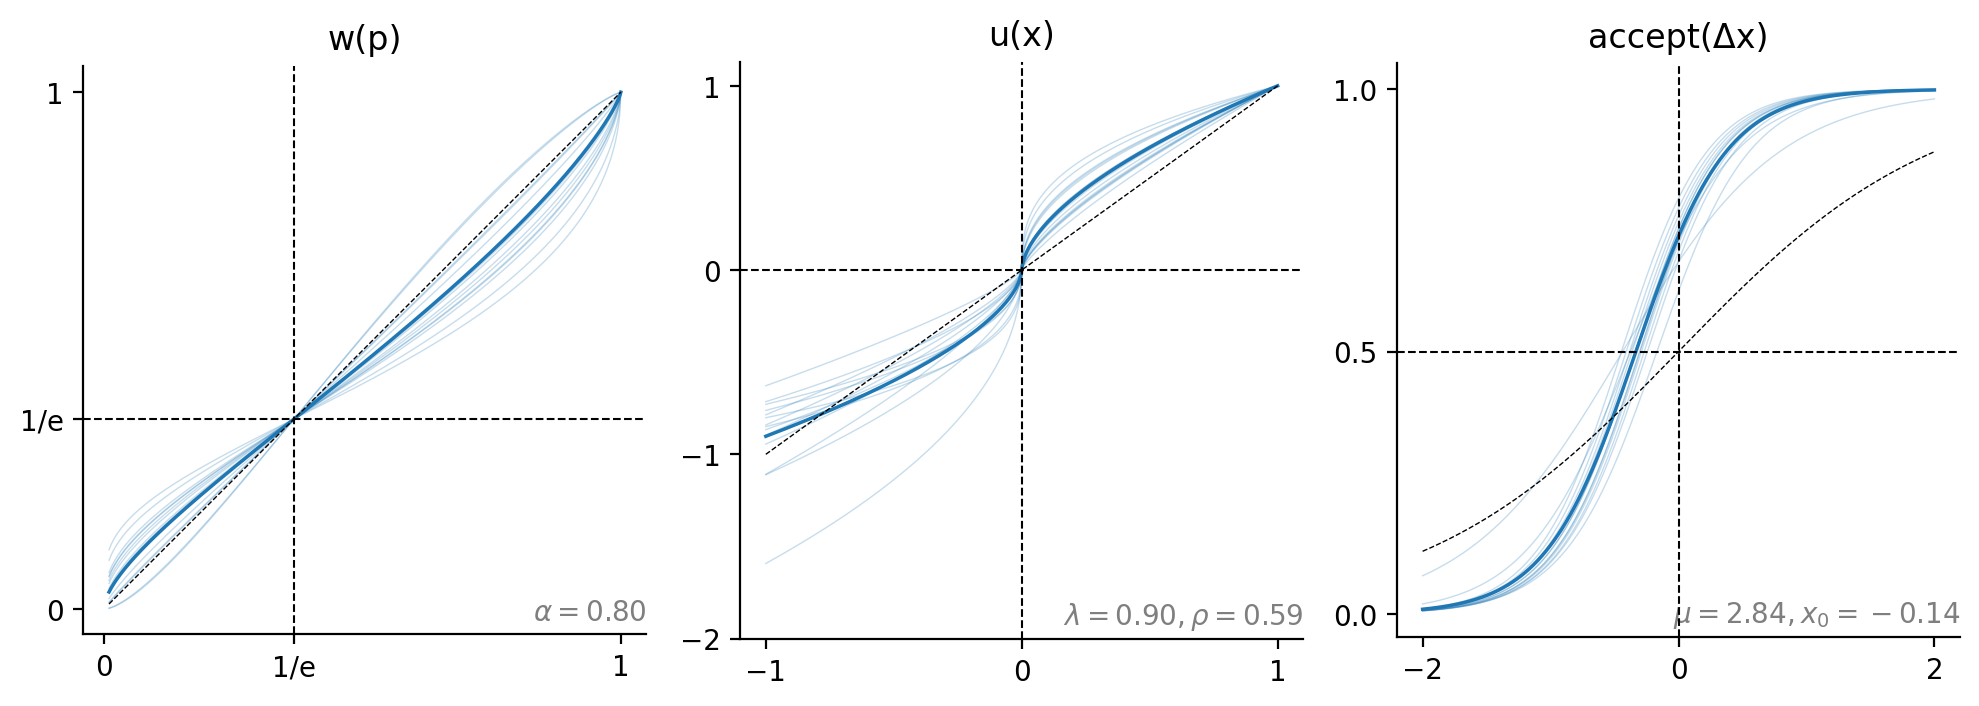

In [12]:
def plot(ax, f, xlimits):
    """ Convenience functon to factorize code"""
    
    xmin, xmax = xlimits
    X = np.linspace(xmin, xmax, 500)
    for p in fits.values():
        ax.plot(X, f(X, p), color="C0", lw=0.5, alpha=0.25)
    ax.plot(X, f(X, mean_fit), color="C0", lw=1.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return X


fig = plt.figure(figsize=(10,10), dpi=200)


# Subjective probability
# ----------------------
ax = plt.subplot(1, 3, 1, aspect=1)
X = plot(ax, subjective_probability, xlimits=(0.01,1))
ax.plot(X, X, color="black", lw=0.5, ls="--")

x0 = np.exp(-1)
ax.axvline(x0, color="black", ls="--", lw=.75)
ax.axhline(x0, color="black", ls="--", lw=.75)
ax.set_title("w(p)")
ax.set_xticks([0, x0, 1])
ax.set_xticklabels(["0", "1/e", 1])
ax.set_yticks([0, x0, 1])
ax.set_yticklabels(["0", "1/e", 1])
ax.text(1, 0.025, r"$\alpha = %.2f$" % mean_fit["alpha"],
        ha="right", alpha=.5, transform=ax.transAxes)


# Subjective utility
# ------------------
ax = plt.subplot(1, 3, 2, aspect=.72)
X = plot(ax, subjective_utility, xlimits=(-1,1))
ax.plot(X, X, color="black", lw=0.5, ls="--")

ax.axvline(0, color="black", ls="--", lw=.75)
ax.axhline(0, color="black", ls="--", lw=.75)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-2, -1, 0, 1])
ax.set_title("u(x)")
ax.text(1, 0.025, r"$\lambda = %.2f, \rho=%.2f$" % (mean_fit["lambda"], mean_fit["rho"]),
        ha="right", alpha=.5, transform=ax.transAxes)

# Accept
# ------
ax = plt.subplot(1, 3, 3, aspect=4.1)
X = plot(ax, accept, xlimits=(-2,2))
ax.plot(X, accept(X, {"x0" : 0, "mu" : 1, "bias" : 0}), color="black", lw=0.5, ls="--")
ax.axvline(0.0, color="black", ls="--", lw=.75)
ax.axhline(0.5, color="black", ls="--", lw=.75)
ax.set_title("accept(Δx)")
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 0.5, 1])
ax.text(1, 0.025, r"$\mu = %.2f, x_0=%.2f$" % (mean_fit["mu"], mean_fit["x0"]),
        ha="right", alpha=.5, transform=ax.transAxes);

plt.tight_layout()